# Effects of Loan Characteristics on Borrower Rate
## by Hao Xu

## Investigation Overview

In this investigation, I wanted to look at the characteristics of borrower that could be used to predict the Borrower Rate. I wolud focus on two questions, one is **what are the basic requirements for getting a loan**, the other is **what features are related to borrower rate**.I will focus on a batch of importamt features(such as loan amount, term, credit score, borrower loan history and so on.)

## Dataset Overview

The data consisted 81 loan features, including loan basic information (such as Borrower Rate, Loan amount, Loan Status), Pre-loan management infomation (such as borrower credit information, prosper rating and score, borrower income and de) and Post-loan information (such as loan status, principle outstanding) of approximately 112,000 loans. Because Prosper begin to get every loan's Rate through its algorithm after July 2009, about 27000 loans were removed, they are all loans before July 2009, and their Borrower Rate was produced by auction.  The final dataset contains 84853 rows.


In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

# change the datatype of ListingCreationDate to timestamp
df["ListingCreationDate"] = df["ListingCreationDate"].astype("datetime64")

# get the data after July 2009
df = df[df['ListingCreationDate']>= pd.Timestamp(2009,7,13)]


In [3]:
# set a function to convert columns(with null values) from float datatype to string
def float_to_str(df,col):
    '''
    INPUT:
    df - the pandas dataframe
    col - the column name to convert
    
    OUTPUT:
    str_col - column series with datatype of string
    '''
    def tail(str):
        if str == 'nan':
            return np.NaN
        else:
            return str[:-2]

    new_series = df[col].astype(str).apply(tail)
    
    return new_series

# add a column,'ProsperScore_order' , save the ordinal type of ProsperScore. I need keep the 
# float type for further correlation coefficient computing.
# convert datatype of ProsperScore to string use float_to_str function

df['ProsperScore_order']= float_to_str(df,'ProsperScore')

# convert ProsperRating (Alpha) ProsperScore into ordered categorical types
ordinal_var_dict = {'ProsperRating (Alpha)': ['HR', 'E', 'D', 'C', 'B', 'A', 'AA'],
                    'ProsperScore_order': ['1', '2', '3', '4', '5', '6', '7', '8','9','10','11']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    df[var] = df[var].astype(ordered_var)

In [148]:
# convert ProsperRating (numeric) from float to int, and is better to use int for lables
df['ProsperRating (numeric)'] = df['ProsperRating (numeric)'].astype(int)

## Distribution of Borrower Rate

The distribution of brrower Rate is roughly bimodal with one peak around 15% another around 27%, and is a bit right skewed. There also is a single but very large spike between 31% and 32%.

vast majority of them have amount less than 7500, and are in the lowest two rating categories. It seems that a large part of these borrowers have not good enough qualification, so they have to accecpt a higher APR and smaller amount.


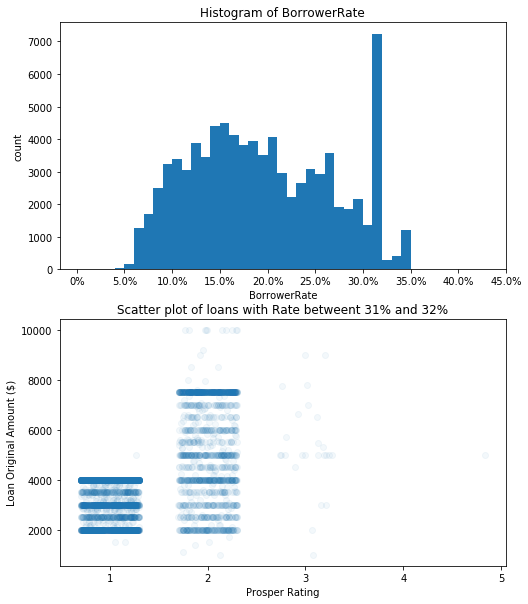

In [230]:
plt.figure(figsize=[8, 10])

# start with a standard-scaled plot
plt.subplot(2,1,1)
bins = np.arange(0, df['BorrowerRate'].max()+0.01, 0.01)
ticks = [0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45]
labels = ['{}%'.format(v*100) for v in ticks]
plt.hist(data = df, x = 'BorrowerRate',bins = bins)
plt.xlabel('BorrowerRate')
plt.ylabel('count')
plt.xticks(ticks, labels )
plt.title('Histogram of BorrowerRate')

# get a scatter plot of rating and amount for the small dataset
plt.subplot(2,1,2)
ticks = [1,2,3,4,5]
df_larger_31 = df.query('0.31 < BorrowerRate <0.32')
sb.regplot(data = df_larger_31, x = 'ProsperRating (numeric)', y = 'LoanOriginalAmount',x_jitter = 0.3,
           scatter_kws = {'alpha':1/20},fit_reg = False);
plt.xticks(ticks,ticks)
plt.title('Scatter plot of loans with Rate betweent 31% and 32%')
plt.xlabel('Prosper Rating')
plt.ylabel('Loan Original Amount ($)')
plt.show();

## Distribution of Loan Original Amount
After apply a log scale, the distribute of Loan Original Amount shows that the amount of most loans are multiples of $500, the most favorite amounts are 4k, 15k and 10k. Most of the loans have a amount less than 15k. 

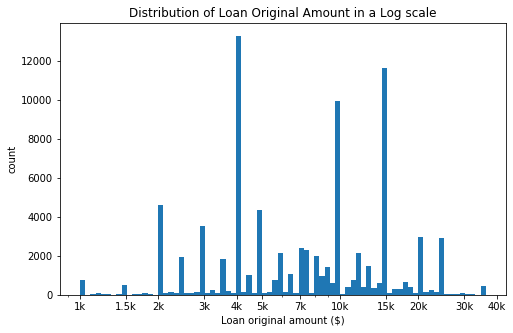

In [16]:
# polt a log scale as addition
plt.figure(figsize=[8, 5])
ticks = [1000,1500,2000,3000,4000,5000,7000,10000,15000,20000,30000,40000]
labels = ['1k','1.5k','2k','3k','4k','5k','7k','10k','15k','20k','30k','40k']
bins = 10 ** np.arange(3, np.log10(df.LoanOriginalAmount.max())+0.02, 0.02)
plt.hist(data = df, x = 'LoanOriginalAmount',bins = bins)
plt.xscale('log')
plt.xticks(ticks,labels)
plt.xlabel('Loan original amount ($)')
plt.ylabel('count')
plt.title('Distribution of Loan Original Amount in a Log scale')
plt.show()

## The basic requirement for a borrower

After Prosper relaunching its business, Prosper set a minimun Credit Score threshold to 600 (this score are provided by a consumer credit rating agency), then around the forth quarter of 2013, it raised its minimun level again to 640. If some can not get a credit score higher than 640 from a third party agency, he/she will not get a loan from prosper.

After 2011, Prosper Prosper rised its minimum loan amount from 1000 to 2000. Around the first quarter of 2013, Prosper began to have loan large than 25000. As a result, Average loan amount is increasing over time.


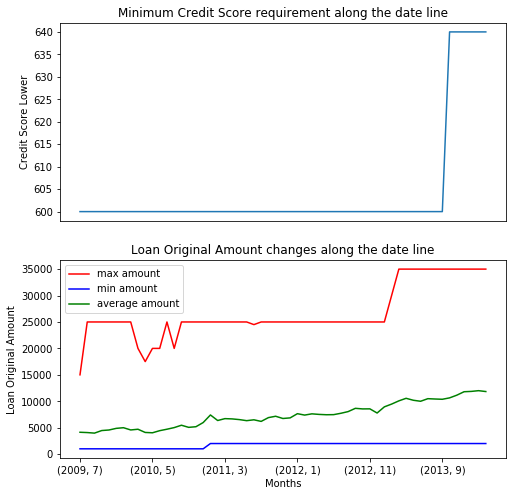

In [231]:
# plot the monthly time distribution of loans
plt.figure(figsize=[8, 8])

plt.subplot(2,1,1)
df.groupby([df["ListingCreationDate"].dt.year,df["ListingCreationDate"].dt.month]).min()['CreditScoreRangeLower'].plot(kind = 'line')
plt.xlabel('')
plt.xticks([])
plt.ylabel('Credit Score Lower')
plt.title('Minimum Credit Score requirement along the date line')

plt.subplot(2,1,2)
df.groupby([df["ListingCreationDate"].dt.year,df["ListingCreationDate"].dt.month]).max()['LoanOriginalAmount'].plot(kind = 'line',color = 'r')
df.groupby([df["ListingCreationDate"].dt.year,df["ListingCreationDate"].dt.month]).min()['LoanOriginalAmount'].plot(kind = 'line',color = 'b')
df.groupby([df["ListingCreationDate"].dt.year,df["ListingCreationDate"].dt.month]).mean()['LoanOriginalAmount'].plot(kind = 'line',color = 'g')
plt.ylabel('Loan Original Amount')
plt.xlabel('Months')
plt.legend(loc = 2,labels = ('max amount', 'min amount', 'average amount'))
plt.title('Loan Original Amount changes along the date line')

plt.show();


## Borrower Rate vs. Prosper Rating

Borrower Rate is highly correlated with Prosper Rating, they produces an approximately linear relationship, the high borrower's rating , the lower the Borrower Rate. It shows that Prosper use their Prosper rating to determin the base borrower Rate.

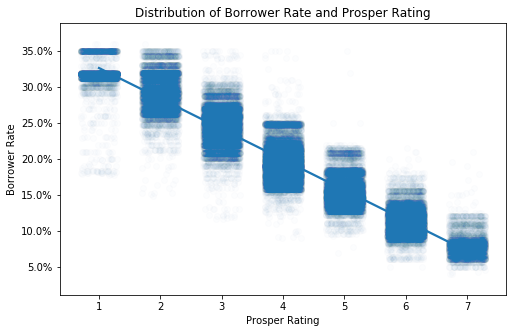

In [63]:
plt.figure(figsize = [8, 5])
yticks = [0.05,0.1,0.15,0.2,0.25,0.3,0.35]
ylabels = ['{}%'.format(v*100) for v in yticks]
sb.regplot(data = df, x = 'ProsperRating (numeric)' , y = 'BorrowerRate', x_jitter = 0.3, scatter_kws = {'alpha':1/100})
plt.xlabel('Prosper Rating')
plt.ylabel('Borrower Rate')
plt.yticks(yticks,ylabels)
plt.title('Distribution of Borrower Rate and Prosper Rating')
plt.show();


## Borrower Rate vs. Term with in each Prosper Rating

Besides Prosper Rating, term is an very important feature affect the Borrower Rate.
Within each Prosper Rating level, the longer the term, the higher the Borrower Rate.


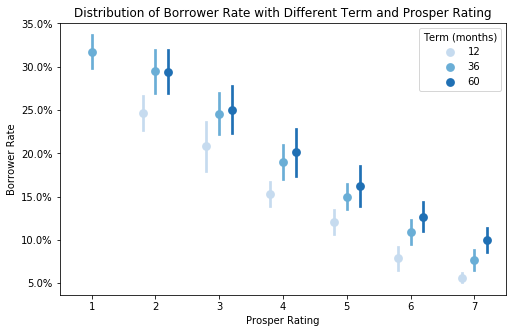

In [118]:
fig = plt.figure(figsize = [8,5])
xticks = [i for i in range(7)]
xlabels = ['{}'.format(v+1) for v in xticks]
yticks = [0.05,0.1,0.15,0.2,0.25,0.3,0.35]
ylabels = ['{}%'.format(v*100) for v in yticks]
ax = sb.pointplot(data = df, x = 'ProsperRating (numeric)', y = 'BorrowerRate', hue = 'Term',
           palette = 'Blues', linestyles = '',dodge = 0.4, ci='sd')
plt.xlabel('Prosper Rating')
plt.xticks(xticks,xlabels)
plt.ylabel('Borrower Rate')
plt.yticks(yticks,ylabels)
plt.legend(title = 'Term (months)' )
plt.title('Distribution of Borrower Rate with Different Term and Prosper Rating');



## Borrower Rate by Delinquencies
After excluding outliers with Delinquencies larger than 9 times (outliers only take about 0.25% of all loans), Delinquencies is positive correlated with Borrower Rate in most of the Prosper Rating categories. But its effect is weaker than term.

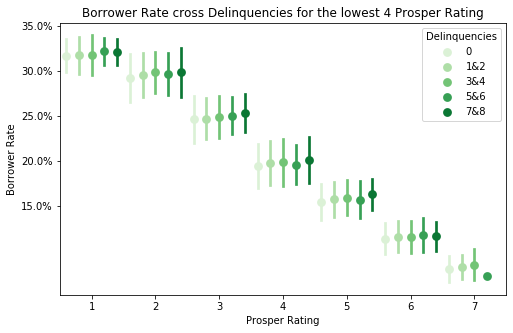

In [237]:
# cut the CurrentDelinquencies feature to several 2 times width bins
bins_amount = np.arange(-2,9,2) 
df['CurrentDelinquencies_binned'] = pd.cut(df['CurrentDelinquencies'], bins_amount, include_lowest = False)
yticks = [0.15,0.2,0.25,0.3,0.35]
ylabels = ['{}%'.format(v*100) for v in yticks]
df2 = df[df['ProsperRating (numeric)'] <= 7]
fig = plt.figure(figsize = [8,5])


ax = sb.pointplot(data = df2, x = 'ProsperRating (numeric)', y = 'BorrowerRate' , hue = 'CurrentDelinquencies_binned',
           palette = 'Greens', linestyles = '',dodge = 0.8, ci='sd',label = tuple(['{}'.format(i) for i in range (10)]))
handles, labels = ax.get_legend_handles_labels()
plt.legend(loc = 1,handles = handles,labels = ('0','1&2','3&4','5&6','7&8'),title = 'Delinquencies')
plt.ylabel('Borrower Rate')
plt.yticks(yticks,ylabels)
plt.title('Borrower Rate cross Delinquencies for the lowest 4 Prosper Rating')
plt.xlabel('Prosper Rating')
plt.show();



## Borrower Rate by Inquiries in Last 6 Months
Just as Delinquencies, after excluding outliers with Inquiries Last6Months larger than 9 times ï¼ˆcoincidentally outliers also take about 0.25% of all loans), Inquiries Last6Months is also positive correlated with Borrower Rate.

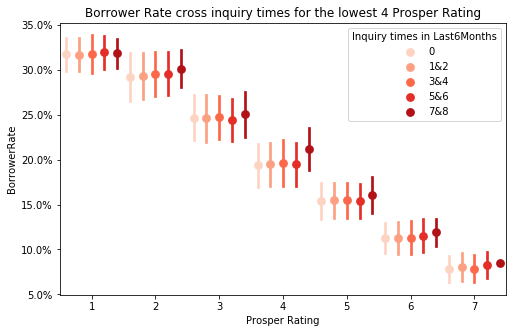

In [241]:
# cut the InquiriesLast6Months feature to several 2 times width bins
bins_amount = np.arange(-2,9,2)
df['InquiriesLast6Months_binned'] = pd.cut(df['InquiriesLast6Months'], bins_amount, include_lowest = False)
yticks = [0.05,0.1,0.15,0.2,0.25,0.3,0.35]
ylabels = ['{}%'.format(v*100) for v in yticks]

fig = plt.figure(figsize = [8,5])
ax = sb.pointplot(data = df, x ='ProsperRating (numeric)', y = 'BorrowerRate' , hue = 'InquiriesLast6Months_binned',
           palette = 'Reds', linestyles = '',dodge = 0.8, ci='sd')
handles, labels = ax.get_legend_handles_labels()
plt.legend(loc = 1,handles = handles,labels = ('0','1&2','3&4','5&6','7&8'),title = 'Inquiry times in Last6Months')
plt.yticks(yticks,ylabels)
plt.title('Borrower Rate cross inquiry times for the lowest 4 Prosper Rating')
plt.xlabel('Prosper Rating')


plt.show();



## Borrower Rate vs. AvailableBankcardCredit  for Higher ProsperRating

For the highest 3 Prosper Rating categories(5,6,7), AvailableBankcardCredit is negative correlated with Borrower Rate. The larger the AvailableBankcardCredit, the lower the Borrower Rate. But this trend does not exist in the other Prosper Rating categories.


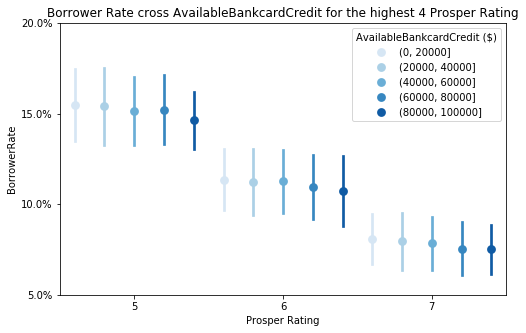

In [243]:
# cut the InquiriesLast6Months feature to several 2 times width bins
bins_amount = np.arange(0,100000+20000,20000)
df['AvailableBankcardCredit_binned'] = pd.cut(df['AvailableBankcardCredit'], bins_amount, include_lowest = False)
yticks = [0.05,0.1,0.15,0.2]
ylabels = ['{}%'.format(v*100) for v in yticks]

df2 = df[df['ProsperRating (numeric)'] >= 5]
fig = plt.figure(figsize = [8,5])
ax = sb.pointplot(data = df2, x ='ProsperRating (numeric)', y = 'BorrowerRate' , hue = 'AvailableBankcardCredit_binned',
           palette = 'Blues', linestyles = '',dodge = 0.8, ci='sd')
handles, labels = ax.get_legend_handles_labels()
plt.legend(loc = 1,handles = handles,title = 'AvailableBankcardCredit ($)')
plt.yticks(yticks,ylabels)
plt.title('Borrower Rate cross AvailableBankcardCredit for the highest 4 Prosper Rating')
plt.xlabel('Prosper Rating')


plt.show();


> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!